The Padé approximant $R_{L,M}(x)$ is a rational function, $P(x) / Q(x)$, where the zeros of the approximant are the roots of the numerator polynomial and the poles of the approximant are the roots of the denominator polynomial.

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

def get_pade_coeffs(c, L, M):
    '''
    Returns the numerator (p) and denominator (q) coefficients for R_L,M.
    '''
    if len(c) < L + M + 1:
        raise ValueError("Not enough coefficients")

    if M == 0:
        return c[:L+1], np.array([1.0])

    A = np.zeros((M, M))
    b = np.zeros(M)
    for i in range(M):
        b[i] = -c[L + 1 + i]
        for j in range(M):
            idx = L + i - j
            if idx >= 0:
                A[i, j] = c[idx]

    try:
        q_solved = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        return None, None

    q_coeffs = np.concatenate(([1.0], q_solved))

    p_coeffs = np.zeros(L + 1)
    for k in range(L + 1):
        p_coeffs[k] = sum(q_coeffs[s] * c[k-s] for s in range(min(k, M) + 1) if k-s >= 0)

    return p_coeffs, q_coeffs

def find_polynomial_roots(coefficients):
    '''
    Finds roots of a polynomial.
    '''
    return np.roots(coefficients[::-1])

In [5]:
def get_binomial_coeffs(num_coeffs, alpha):
    c = np.zeros(num_coeffs)
    c[0] = 1.0
    for k in range(1, num_coeffs):
        c[k] = c[k-1] * (alpha - k + 1) / k
    return c

def get_f1_coeffs(n): return get_binomial_coeffs(n, 0.5)

def get_f3_coeffs(n): return get_binomial_coeffs(n, -0.5)

def get_f4_coeffs(num_coeffs): # exp(x)
    return np.array([1.0 / math.factorial(k) for k in range(num_coeffs)])
def get_f5_coeffs(num_coeffs): # exp(x) / (1+x)
    c_exp = get_f4_coeffs(num_coeffs)
    c_inv = np.array([(-1)**k for k in range(num_coeffs)]) # 1/(1+x)
    # Cauchy product
    c_prod = np.zeros(num_coeffs)
    for n in range(num_coeffs):
        c_prod[n] = np.dot(c_exp[:n+1], c_inv[n::-1])
    return c_prod

def get_f6_coeffs(num_coeffs): # sqrt(1+x+x^2)
    # Use expansion of sqrt(1+g) where g = x+x^2
    c_sqrt = get_binomial_coeffs(num_coeffs, 0.5) # Coeffs for sqrt(1+u)
    c_final = np.zeros(num_coeffs)
    # Let g(x) = x + x^2. We need to compute (g(x))^k and collect powers.
    # This can be done by convolving [0, 1, 1] with itself repeatedly.
    g_coeffs = np.array([0, 1, 1])
    g_power_k_coeffs = np.array([1.0]) # g^0 = 1

    for k in range(num_coeffs):
        # Contribution from c_sqrt[k] * g^k
        if k > 0:
            g_power_k_coeffs = np.convolve(g_power_k_coeffs, g_coeffs)

        term_contribution = c_sqrt[k] * g_power_k_coeffs
        # Add contribution to final coeffs
        max_len = min(num_coeffs, len(term_contribution))
        c_final[:max_len] += term_contribution[:max_len]

    return c_final

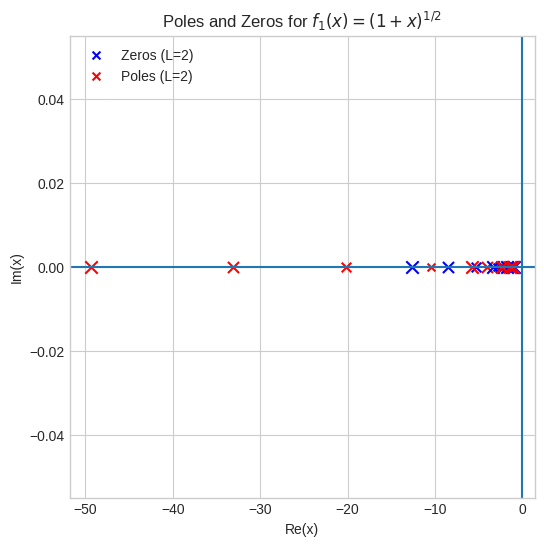

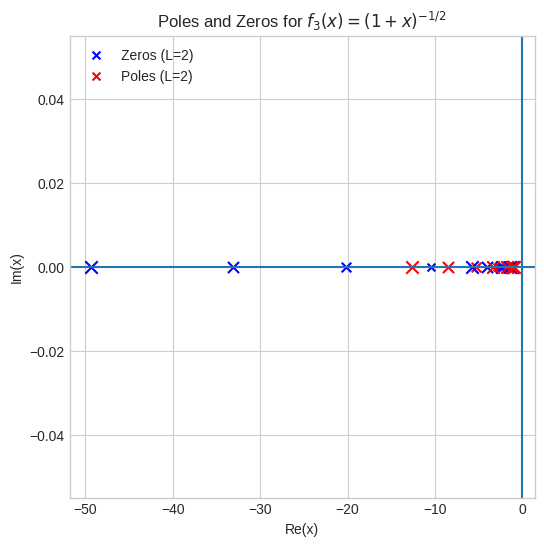

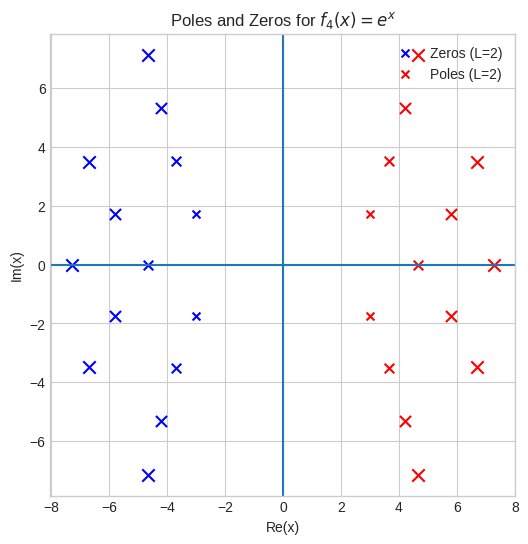

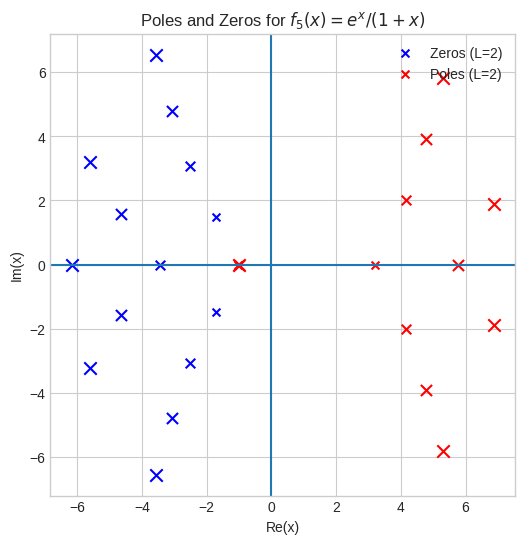

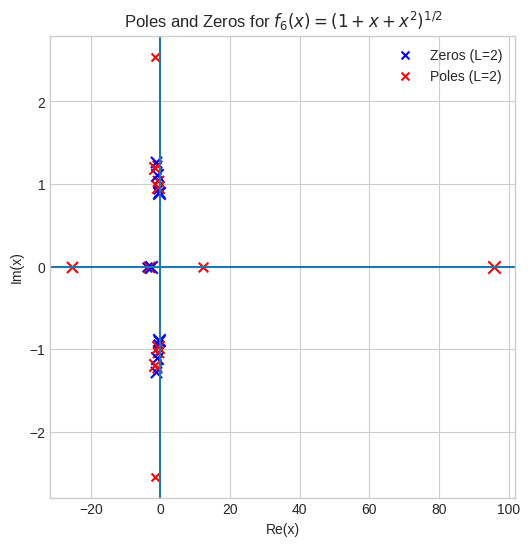

In [34]:
def plot_poles_and_zeros(coeff_func, title, L_values):
    fig, ax = plt.subplots(figsize=(6, 6))

    max_coeff_needed = 2 * max(L_values) + 1
    coeffs = coeff_func(max_coeff_needed)

    for l_val in L_values:
        p, q = get_pade_coeffs(coeffs, l_val, l_val)

        if p is None: continue

        zeros = find_polynomial_roots(p)
        poles = find_polynomial_roots(q)
        marker_size = l_val * 16
        ax.scatter(np.real(zeros), np.imag(zeros), marker='x', c='blue', s=marker_size, label=f'Zeros (L={l_val})' if l_val==L_values[0] else "")
        ax.scatter(np.real(poles), np.imag(poles), marker='x', c='red', s=marker_size, label=f'Poles (L={l_val})' if l_val==L_values[0] else "")

    ax.set_xlabel("Re(x)")
    ax.set_ylabel("Im(x)")
    ax.set_title(title)
    ax.grid(True)
    ax.axhline(0)
    ax.axvline(0)
    ax.legend(loc='best')
    plt.show()

L_vals = [2, 3, 4, 5]
plot_poles_and_zeros(get_f1_coeffs, 'Poles and Zeros for $f_1(x) = (1+x)^{1/2}$', L_vals)
plot_poles_and_zeros(get_f3_coeffs, 'Poles and Zeros for $f_3(x) = (1+x)^{-1/2}$', L_vals)
plot_poles_and_zeros(get_f4_coeffs, 'Poles and Zeros for $f_4(x) = e^x$', L_vals)
plot_poles_and_zeros(get_f5_coeffs, 'Poles and Zeros for $f_5(x) = e^x / (1+x)$', L_vals)
plot_poles_and_zeros(get_f6_coeffs, 'Poles and Zeros for $f_6(x) = (1+x+x^2)^{1/2}$', L_vals)

1.  $f_1(x) = (1 + x)^{1/2}$

    This function has a branch point at $x = -1$. The function is multi-valued and the standard choice for the branch cut is the real axis from $(-\infty, -1]$. As $L$ increases, the poles and zeros move towards the negative real axis and appear to be mapping out the branch cut from $(-\infty, -1)$, alternating between pole and zero.

2.  $f_3(x) = (1 + x)^{-1/2}$

    Similar to $f_1(x)$, this function also has a branch point at $x = -1$ and a branch cut along $(-\infty, -1]$, but with the zeros and poles inverted, as expected. As $L$ increases, the poles and zeros of the Padé approximant converge to the negative real axis, outlining the branch cut.

3.  $f_4(x) = e^x$
    
    The exponential function is an entire function, meaning it has no singularities (no poles or branch points) in the finite complex plane. As $L$ increases, the poles and zeros move radially outward, away from the origin. The poles and zeros are pushed far away, which is how a rational function with a finite number of poles and zeros approximates a function with none.

4.  $f_5(x) = \frac{e^x}{1 + x}$
    
    This function is the product of the entire $e^x$ and a function with a simple pole $(1+x)^{-1}$. For every value of $L$, one of the poles of the Padé approximant is located very close and indeed converges to $-1$. The other poles and zeros move away from the origin as before. The Padé approximant has isolated the single pole of the function and pushes every other zero and pole away to infinity.

5.  $f_6(x) = (1 + x + x^2)^{1/2}$

    This function has two branch points at the complex conjugates $x_{\pm} = -\frac{1}{2} \pm \frac{i\sqrt{3}}{2}$. The branch cut for this function connects these two points. As $L$ increases, the poles and zeros arrange themselves in an arc, converging to the line segment in the complex plane that connects the two branch points, alternating pole and zero across the arac.

The Padé approximants model the function's branch cut by arranging a series of alternating poles and zeros that converge to the location of the cut as $L$ increases. The single-valued rational approximant mimics a multi-valued function by creating a high density of singularities and roots along the path where the function is discontinuous.

The approximant can also identify isolated singularities or zeros as a pole or zero of the approximant rapidly converges to the true pole or zero. The remaining anomalous poles and zeros then move out towards infinity to model the entire part of the function.

Some anomalous poles and zeros are those that do not correspond to a specific singularity of the approximated function. Their purpose is to cancel each other out in the region of interest and move to infinity to emulate the entire behavior of the exponential function.

Other anomalous poles and zeros are not modeling a new feature of the function. They are artifacts of numerical imprecision. As $L$ increases, the problem of finding the Padé coefficients involves solving a linear system with a matrix where accumulating floating-point representation errors cause the roots of the polynomials to deviate.

In particular, when we estimate $f_6$ along the real axis, the poles of the approximate converge towards the branch cut and pass close to the real axis. The small imaginary part causes the denominator of the approximant becomes very small for values on the real line close to a pole, causing a spike in the approximation.